In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
from medmnist import ChestMNIST
from PIL import Image
import cv2

In [14]:
def load_data(data_split, image_nxn_size, n_observations):
    data = ChestMNIST(split=data_split, download=True, size=image_nxn_size)

    if n_observations > 0:
        images = data.imgs[0:n_observations]
        labels = data.labels[0:n_observations]
    else:      
        images = data.imgs
        labels = data.labels

    del data

    return images, labels

In [15]:
train_images, train_labels = load_data(data_split="train", image_nxn_size=28, n_observations=1000)
validation_images, validation_labels = load_data(data_split="val", image_nxn_size=28, n_observations=1000)
test_images, test_labels = load_data(data_split="test", image_nxn_size=28, n_observations=1000)

Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist.npz


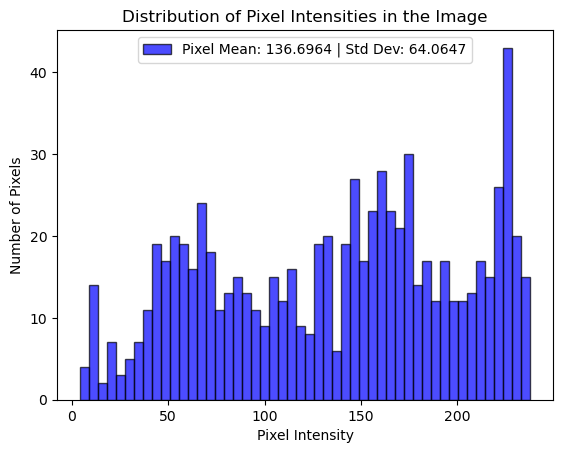

In [ ]:
raw_image = train_images[0]
pixels = raw_image.flatten()

plt.hist(pixels, bins=50, alpha=0.7, color='blue', edgecolor='black', label=f'Pixel Mean: {np.mean(pixels):.4f} | Std Dev: {np.std(pixels):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.show()


In [ ]:
# def preprocess_data(image_set):
#     preprocess = transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     transformed_images = []

#     for image in tqdm.tqdm(image_set):
#         image = np.float32(image) / 255.0
#         image = Image.fromarray(image)
#         transformed_images.append(preprocess(image))

#     return torch.stack(transformed_images)

In [ ]:
# x_train_tensor = preprocess_data(train_images)
# x_validation_tensor = preprocess_data(validation_images)
# x_test_tensor = preprocess_data(test_images)

100%|██████████| 1000/1000 [00:00<00:00, 13916.53it/s]


In [ ]:
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def preprocess_images(images):
    transformed_images = []
    for img in images:
        img = Image.fromarray(img.astype(np.uint8))
        transformed_img = data_transform(img)
        transformed_images.append(transformed_img)

    return torch.stack(transformed_images)

preprocessed_images = preprocess_images(train_images)


torch.Size([1000, 3, 224, 224])


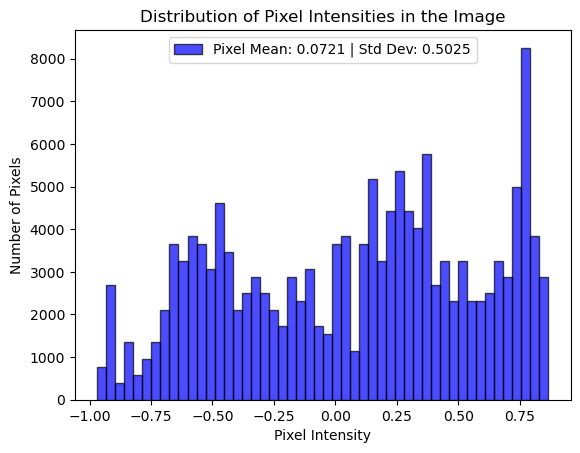

In [ ]:
raw_image = preprocessed_images[0]
pixels = raw_image.flatten()

mean_pixel = torch.mean(pixels).item()
std_pixel = torch.std(pixels).item()

plt.hist(pixels.numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black', label=f'Pixel Mean: {mean_pixel:.4f} | Std Dev: {std_pixel:.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.show()


In [28]:
x_train_tensor = preprocess_images(train_images)
x_validation_tensor = preprocess_images(validation_images)
x_test_tensor = preprocess_images(test_images)

In [20]:
# Debugging
# num_images = len(transformed_images)
# image_size = transformed_images[0].numel()  # Number of elements in one image
# dtype_size = transformed_images[0].element_size()  # Size of each element in bytes
# total_memory = num_images * image_size * dtype_size
# print(f"Total memory required: {total_memory / (1024 ** 3):.2f} GB")

In [ ]:
y_train_tensor = torch.tensor(train_labels)
y_validation_tensor = torch.tensor(validation_labels)
y_test_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(x_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  

In [30]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT, progress=True)

if True:
    for param in model.parameters():
        param.requires_grad = False

    # for param in model.layer3.parameters():
    #     param.requires_grad = True

    for param in model.layer4.parameters():
        param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, train_labels.shape[1], bias=True)

In [31]:
optimizer = optim.Adam(model.parameters(), lr = 0.1)
#scheduler = StepLR(optimizer, step_size = 2, gamma = 0.5)

#class_counts = torch.sum(y_train_tensor, dim=0).float()
#pos_weight = 1.0 / class_counts
criterion = nn.BCEWithLogitsLoss()

In [35]:
num_epochs = 100
lr = 0.001
gamma=0.1
milestones = [0.5 * num_epochs, 0.75 * num_epochs]

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# Loss function (cross entropy for classification)
loss_func = nn.BCEWithLogitsLoss()

In [36]:
best_model_path = "best_transfer_learning_model.pth"
best_loss = np.inf
best_score = 0
best_epoch = 0
sigmoid_threshold = 0.5

for epoch in range(10):
    model.train()
    
    for inputs, targets in tqdm.tqdm(train_loader, desc="Training: "):
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.float()

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    all_targets = []
    all_predictions = []
    validation_loss = 0.0
    validation_accuracy = 0.0
    
    with torch.no_grad():
        for validation_inputs, validation_targets in validation_loader:
            validation_outputs = model(validation_inputs)
            validation_targets = validation_targets.float()
            validation_loss += criterion(validation_outputs, validation_targets)

            probabilities = torch.sigmoid(validation_outputs)
            predictions = (probabilities > sigmoid_threshold).float()

            all_targets.extend(validation_targets)
            all_predictions.extend(probabilities)

    validation_score = roc_auc_score(all_targets, all_predictions, average="macro")
    validation_loss /= len(validation_loader.dataset)

    if validation_loss < best_loss:
        best_loss = validation_loss
    
    if validation_score > best_score:
        best_score = validation_score
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch: {epoch + 1}, Validation Loss: {validation_loss}, ROC AUC: {validation_score}")

Training: 100%|██████████| 16/16 [01:08<00:00,  4.31s/it]


Epoch: 1, Validation Loss: 0.002735388930886984, Macro Average Precision: 0.6254092109595375


Training: 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


Epoch: 2, Validation Loss: 0.002732916735112667, Macro Average Precision: 0.6290441741503328


Training: 100%|██████████| 16/16 [01:07<00:00,  4.25s/it]


Epoch: 3, Validation Loss: 0.002728925785049796, Macro Average Precision: 0.6328060392763407


Training: 100%|██████████| 16/16 [01:05<00:00,  4.10s/it]


Epoch: 4, Validation Loss: 0.0027264654636383057, Macro Average Precision: 0.6336996228875468


Training: 100%|██████████| 16/16 [01:06<00:00,  4.14s/it]


Epoch: 5, Validation Loss: 0.0027265679091215134, Macro Average Precision: 0.6350519673918092


Training: 100%|██████████| 16/16 [01:15<00:00,  4.71s/it]


Epoch: 6, Validation Loss: 0.002727207262068987, Macro Average Precision: 0.6355840865061989


Training: 100%|██████████| 16/16 [01:17<00:00,  4.81s/it]


Epoch: 7, Validation Loss: 0.0027258731424808502, Macro Average Precision: 0.6371017774901687


Training: 100%|██████████| 16/16 [01:15<00:00,  4.73s/it]


Epoch: 8, Validation Loss: 0.002727237995713949, Macro Average Precision: 0.6370352736430946


Training: 100%|██████████| 16/16 [01:23<00:00,  5.21s/it]


Epoch: 9, Validation Loss: 0.002730422420427203, Macro Average Precision: 0.6377476555242199


Training: 100%|██████████| 16/16 [01:05<00:00,  4.08s/it]


Epoch: 10, Validation Loss: 0.0027277451008558273, Macro Average Precision: 0.6401526014224042


In [46]:
model.load_state_dict(torch.load("best_transfer_learning_model.pth", weights_only=True))
model.eval()

all_targets = []
all_predictions = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_targets in tqdm.tqdm(test_loader, desc="Testing:"):
        test_outputs = model(test_inputs)
        test_targets = test_targets.float()
        test_loss += criterion(test_outputs, test_targets)

        probabilities = torch.sigmoid(test_outputs)
        predictions = (probabilities > sigmoid_threshold).float()

        all_targets.extend(test_targets)
        all_predictions.extend(predictions)

print(all_predictions)
test_loss /= len(test_loader.dataset)
test_hamming_loss = hamming_loss(all_targets, all_predictions)
test_accuracy = accuracy_score(all_targets, all_predictions)
test_precision = precision_score(all_targets, all_predictions, average="macro")
test_recall = recall_score(all_targets, all_predictions, average="macro")
test_f1_score = f1_score(all_targets, all_predictions, average="macro")
test_roc_auc = roc_auc_score(all_targets, all_predictions, average="macro")

print(f"Test Loss: {test_loss}")
print(f"Hamming Loss: {test_hamming_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1_score}")
print(f"ROC AUC: {test_roc_auc}")


Testing:: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
/opt/anaconda3/envs/DS440_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0

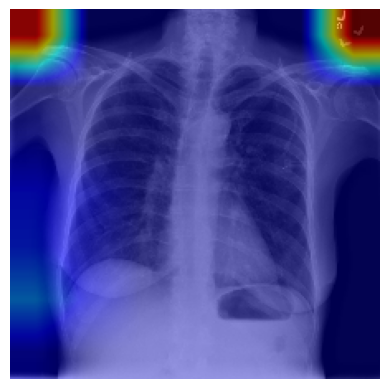

In [ ]:
model.load_state_dict(torch.load("best_transfer_learning_model.pth", weights_only=True))
model.eval()

target_layers = [model.layer4[-1]]

image = Image.open("./Example Images/Infiltration.PNG").convert("RGB")
input_tensor = data_transform(image).unsqueeze(0)

targets = [ClassifierOutputTarget(i) for i in range(0, 15)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    rgb_img = np.array(image) / 255.0
    rgb_img = cv2.resize(rgb_img, (224, 224))

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

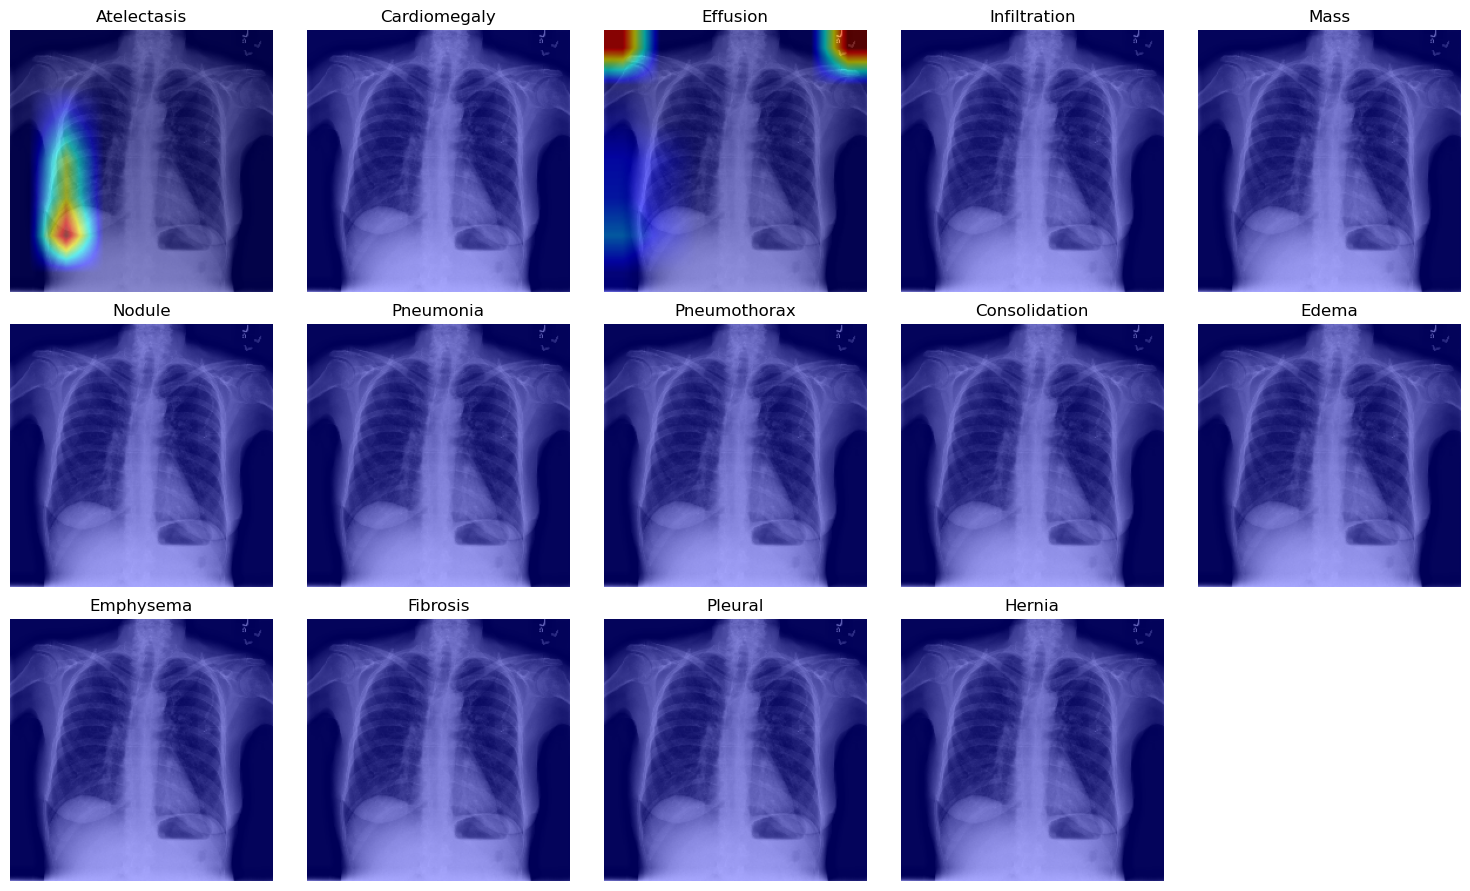

In [68]:
import math


model.load_state_dict(torch.load("best_transfer_learning_model.pth", weights_only=True))
model.eval()

target_layers = [model.layer4[-1]]

image = Image.open("./Example Images/Infiltration.PNG").convert("RGB")
input_tensor = data_transform(image).unsqueeze(0)

targets = [ClassifierOutputTarget(i) for i in range(0, 14)]

labels = {
    0: "Atelectasis",
    1: "Cardiomegaly",
    2: "Effusion",
    3: "Infiltration",
    4: "Mass",
    5: "Nodule",
    6: "Pneumonia",
    7: "Pneumothorax",
    8: "Consolidation",
    9: "Edema",
    10: "Emphysema",
    11: "Fibrosis",
    12: "Pleural",
    13: "Hernia"
}

# Calculate the number of rows and columns needed for the facet grid
num_targets = len(targets)
cols = 5  # Set number of columns (you can adjust this number)
rows = math.ceil(num_targets / cols)  # Calculate the number of rows

# Create the facet grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each target and create a subplot for each target
for idx, target in enumerate(targets):
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=[target])
        grayscale_cam = grayscale_cam[0, :]

        rgb_img = np.array(image) / 255.0
        rgb_img = cv2.resize(rgb_img, (224, 224))

        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Assign the visualization to the correct subplot
        ax = axes[idx]
        ax.imshow(visualization)
        ax.axis('off')
        ax.set_title(f"{labels[idx]}")  # Use idx as the target label

# Remove any unused axes
for j in range(num_targets, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
